# Comptage routier - Données trafic issues des capteurs permanents


Grâce à l'open data de Paris nous avons accès aux données de trafic routier issues des capteurs permanennts. Ces capteurs mesurent le trafic routier en débit horaire, taux d'occupation et classe chaque mesure en fonction des résultats selon si le trafic est Fluide, Pré-saturé, Saturé ou Inconnu toutes les heures. Les données sont disponibles sur une année glissante. J'ai récupéré les données le Novembre 2022, donc celles-ci vont du 1er Novembre 2021 au 31 Octobre 2022.

In [1]:
#éxecution du notebook sur Colab, python version 3.8.16
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Instructions for updating:
non-resource variables are not supported in the long term


## 1. Traitement des données

### 1.1. Chargement des données

Utilisation des champs suivants : 
* Date et heure
* Débit horaire
* Taux d'occupation
* État du trafic
* Localisation du capteur


In [ ]:
# df = pd.read_csv('paris.csv', sep=';', usecols=[2,3,4,5,13], parse_dates=True, index_col=0).to_hdf('paris.h5', 'df', mode='w') this line is used to convert the csv file to hdf5 file because hdf5 is faster to read and takes less memory space than csv file
df = pd.read_hdf('paris.h5', 'df')

### 1.2. Nettoyage des données

* Conversion des données de localisation en 2 colonnes : latitude et longitude
* Suppression des lignes avec des valeurs manquantes

In [2]:
#split geo_point_2d into two columns and drop the original
df[['lat','lon']] = df.geo_point_2d.str.split(',',expand=True)
df.drop('geo_point_2d', axis=1, inplace=True)

print(df.shape, "before dropping null values")
#drop rows with missing values
df = df.dropna(axis=0, how='any')

#remove empty strings from Débit horaire
df = df[df['Débit horaire'].astype(bool)]

#verify that there is no null values
print(df.isnull().sum())
print(df.shape, "after dropping null values")
#format date column to datetime
df.index = pd.to_datetime(df.index, utc=True)

#order by date
df.sort_index()

#aperçu des données de trafic 
df.head()

(21743999, 5) before dropping null values
Débit horaire        0
Taux d'occupation    0
Etat trafic          0
lat                  0
lon                  0
dtype: int64
(8239867, 5) after dropping null values


Débit horaire  Taux d'occupation Etat trafic  \
Date et heure de comptage                                                 
2021-11-02 18:00:00+00:00          919.0           47.91111      Saturé   
2022-01-02 19:00:00+00:00          254.0            4.50611      Fluide   
2022-03-03 05:00:00+00:00          176.0            1.05723      Fluide   
2022-08-02 13:00:00+00:00          761.0            8.96833      Fluide   
2022-10-05 13:00:00+00:00          580.0           21.29278  Pré-saturé   

                                          lat                 lon  
Date et heure de comptage                                          
2021-11-02 18:00:00+00:00  48.866391010292745   2.351773724351662  
2022-01-02 19:00:00+00:00  48.853584029564495    2.32988311847408  
2022-03-03 05:00:00+00:00    48.8825675711191   2.370346027026502  
2022-08-02 13:00:00+00:00   48.86050336404037    2.31325071856321  
2022-10-05 13:00:00+00:00   48.88601233176442  2.3494556174902623

### 1.3. Visualisation des données sur une carte

Création d'une heatmap des donées de trafic pour chacun des capteurs sur 12 frames (1 par mois). La couleur de la heatmap est définie en fonction du débit horaire. On remarque que pour certains points, ke trafic "disparaît" pendant une période. Cela peut être dû à un problème de capteur.

In [3]:
#draw the points where measurements were taken on a map using folium

import folium
from folium import plugins
from folium.plugins import HeatMap, HeatMapWithTime
m = folium.Map(location=[48.8566, 2.3522], zoom_start=13) #Paris coordinates

#divide dataset into 12 equal dataframes, one for each month
df_list = np.array_split(df, 12)
data_hm = []
for df_month in df_list:
#get the average Débit horaire for each month for each point
    df_month.drop(['Etat trafic','Taux d\'occupation'], axis=1, inplace=True)
    df_month = df_month.groupby(['lat','lon']).mean()
    df_month.reset_index(inplace=True)
    df_month.values.tolist()
    data_hm.append(df_month.values.tolist())

#make a heatmap with time
HeatMapWithTime(data=data_hm).add_to(m)
m

### 1.4. Visualisation du taux d'occupation sur un graphe pour un capteur donné sur 500 heures (acquisition toutes les heures)

<ipython-input-4-0feb07be4f66>:13: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  plt.plot(df[(df['lat']==lat) & (df['lon']==lon)]["Taux d'occupation"][time:time+np.timedelta64(500,'h')])


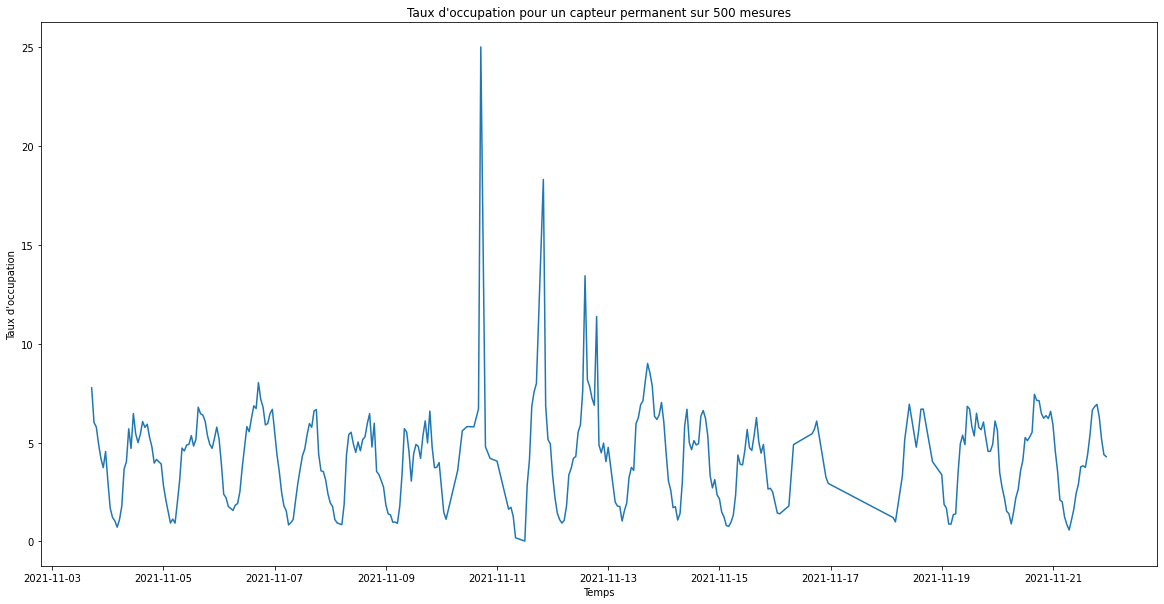

In [4]:
#get random sample from the dataset, sorting by date and avoiding the last 500 values for each points
df.sort_index(inplace=True)
sample = df[:df.size//500].sample(1)

#get lat, lon and time values from the sample
lat = sample['lat'].values[0]
lon = sample['lon'].values[0]
time = sample.index.values[0]

#plot the occupation rate for the random lat, lon position in the dataset for the 500 time steps
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(df[(df['lat']==lat) & (df['lon']==lon)]["Taux d'occupation"][time:time+np.timedelta64(500,'h')])
plt.title("Taux d'occupation pour un capteur permanent sur 500 mesures")
plt.xlabel('Temps')
plt.ylabel("Taux d'occupation")
plt.show()

On remarque que le trafic semble périodique avec des pics aux heures de pointe. Il serait donc possible d'entraîner un modèle sur ces données pour prédire le trafic à une heure donnée dans un quartier donné.

J'ai choisi de restreindre l'étude aux données autour de la gare Montparnasse. C'est un endroit stratégique de Paris où le trafic est très important. On peut donc s'attendre à ce que les données soient intéressantes et que le modèle soit performant.

### 1.5. Visualisation des points choisis sur une carte

#### 1.5.1. Création d'un cercle de 1km autour de la gare Montparnasse.

In [5]:
#create a point at gare Montparnasse
folium.Marker(location=[48.841364, 2.320550],popup='Gare Montparnasse',icon=folium.Icon(color='red',icon='train', prefix='fa')).add_to(m)

#create a circle around gare Montparnasse (1km radius)
folium.Circle(location=[48.841364, 2.320550],popup="Cercle d'1km de rayon",radius=1000,color='blue',fill=True,fill_color='blue',fill_opacity=0.1).add_to(m)
m

#### 1.5.2. Sélection des points dans le cercle dans le dataframe

In [6]:
#limit the dataset to all the points in a 1km radius around gare Montparnasse (coordinates: 48.841364, 2.320550)
import geopy.distance
coords = df[['lat','lon']].drop_duplicates()

coords['dist'] = coords.apply(lambda x: geopy.distance.distance((48.841364, 2.320550), (x['lat'], x['lon'])).km, axis=1)
coords = coords[coords['dist']<1]
df = df[df['lat'].isin(coords['lat']) & df['lon'].isin(coords['lon'])]

#redraw the heatmap with time, this time with only the points in the 1km radius around gare Montparnasse
newmap = folium.Map(location=[48.841364, 2.320550], zoom_start=14) #Montparnasse coordinates

df_list = np.array_split(df, 12)
data_hm = []
for df_month in df_list:
    df_month.drop(['Etat trafic','Taux d\'occupation'], axis=1, inplace=True)
    df_month = df_month.groupby(['lat','lon']).mean()
    df_month.reset_index(inplace=True)
    df_month.values.tolist()
    data_hm.append(df_month.values.tolist())

HeatMapWithTime(data=data_hm).add_to(newmap)
folium.Marker(location=[48.841364, 2.320550],popup='Gare Montparnasse',icon=folium.Icon(color='red',icon='train', prefix='fa')).add_to(newmap)
folium.Circle(location=[48.841364, 2.320550],popup="Cercle d'1km de rayon",radius=1000,color='blue',fill=True,fill_color='blue',fill_opacity=0.1).add_to(newmap)
newmap

### 1.6. Extraction des informations relatives à la date

In [7]:
df['day of the week'] = df.index.dayofweek
df['day of the year'] = df.index.dayofyear
df['hour of the day'] = df.index.hour
df['number of the week'] = df.index.weekofyear

<ipython-input-7-da251c23870f>:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['number of the week'] = df.index.weekofyear


### 1.7. Séléction des features et labels

Dans le label on a le débit horaire de la circulation et dans les features on a la position du capteur, le jour de la semaine, le jour de l'année, l'heure, et le numéro de semaine.

In [8]:
features = ['lat','lon','day of the week','day of the year','hour of the day','number of the week']
labels = ['Débit horaire']
inputs = features + labels

df = df[inputs]

### 1.8. Normalisation des données

In [9]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)

### 1.9. Données d'entraînement et données de test

#### 1.9.1. Séparation des données en données d'entraînement et données de test

In [10]:
def split_data(data, test_size=0.25):
    """
    splits data to training and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    
    df_train, df_test = data.iloc[:ntest], data.iloc[ntest:]
    
    return df_train, df_test

#split the dataset into train and test sets
train, test = split_data(df_scaled)

#### 1.9.2. Affichage des données d'entraînement et de test

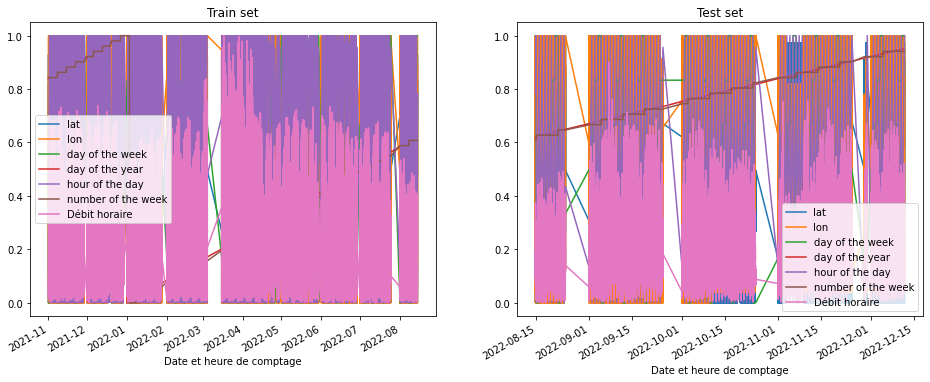

In [11]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

train.plot(ax=ax1, title='Train set')
test.plot(ax=ax2, title='Test set')

### 1.10. Création des batchs

In [12]:
#function to generate batches of data
def batch_generator(batch_size, sequence_length, num_features, num_labels, num_test, x, y):
    while True:
        # Allocate a new array for the input data batch
        x_shape = (batch_size, sequence_length, num_features)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the output data batch
        y_shape = (batch_size, sequence_length, num_labels)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            if num_test<sequence_length:
                print("Error: num_test must be greater than sequence_length", num_test)
            idx = np.random.randint(num_test - sequence_length)

            # Copy the sequences of data starting at this index.
            x_batch[i] = x[idx:idx+sequence_length]
            y_batch[i] = y[idx:idx+sequence_length]

        yield (x_batch, y_batch)

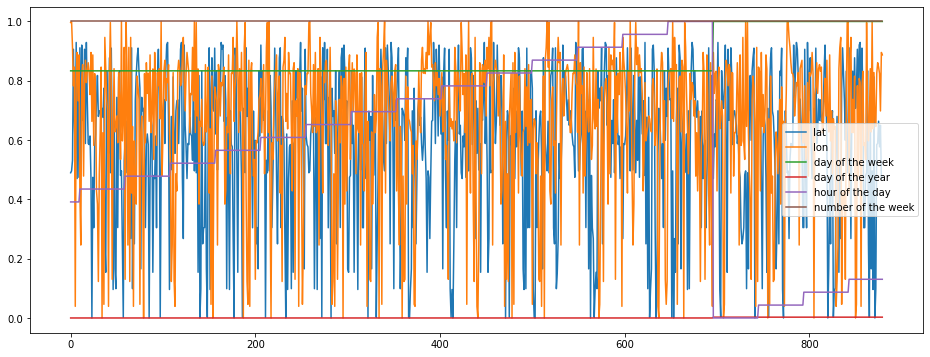

In [13]:
x_train_scaled = np.asarray(train[features])
y_train_scaled = np.asarray(train[labels])

x_test_scaled = np.asarray(test[features])
y_test_scaled = np.asarray(test[labels])

num_test = len(test)
num_train = len(train)
num_total = len(df_scaled)

num_features = len(features)
num_labels = len(labels)
num_inputs = num_features + num_labels

batch_size = 50
sequence_length = 8*coords.shape[0] #par expérience, 8*coords.shape[0] semble valoir 24h

generator = batch_generator(batch_size, sequence_length, num_features, num_labels, num_train, x_train_scaled, y_train_scaled)
testgenerator = batch_generator(batch_size, sequence_length, num_features, num_labels, num_test, x_test_scaled, y_test_scaled)

x_batch, y_batch = next(generator)

seq = x_batch[0]
plt.figure(figsize=(16,6))
plt.plot(seq)
plt.legend(features)
plt.show()

## 2. Création du modèle de prédiction

Modèle choisi : dynamique RNN avec `num_layers` cellules LSTM et une couche dense en sortie. Le modèle est entraîné sur `num_iter` itérations.

In [15]:
from tensorflow.keras.utils import Progbar #from tensorflow.python.keras.utils.generic_utils import Progbar selon la version de tensorflow

num_neurons = 100
learning_rate = 0.001
num_layers = 4
num_iter = 200
keep_prob = 0.2

next(testgenerator)
graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, [None, sequence_length, num_features], name="x")
    y = tf.placeholder(tf.float32, [None, sequence_length, num_labels], name="y") 

    def get_a_cell(lstm_size, keep_prob):
            lstm = tf.nn.rnn_cell.LSTMCell(lstm_size)
            drop = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob)
            return drop
    
    with tf.name_scope('lstm'):
        cell = tf.nn.rnn_cell.MultiRNNCell([get_a_cell(num_neurons, 1-keep_prob) for _ in range(num_layers)])

    outputs, current_state = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

    stacked_rnn_output = tf.reshape(outputs, [-1, num_neurons])           #change the form into a tensor
    stacked_outputs = tf.layers.dense(stacked_rnn_output, num_labels)        #specify the type of layer (dense)
    outputs = tf.reshape(stacked_outputs, [-1, sequence_length, num_labels])          #shape of results

    loss = tf.losses.mean_squared_error(y, outputs)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
     
    train = optimizer.minimize(loss)    
    init = tf.global_variables_initializer()
    with tf.Session(graph=graph) as sess:
        sess.run(init)
        histogram_summary = tf.summary.scalar('MSE', loss)
        merged = tf.summary.merge_all()
        writer = tf.summary.FileWriter('./graphs', sess.graph)
        progbar = Progbar(num_iter)
                
        for iter in range(num_iter):
            x_batch, y_batch = next(generator)
            _current_state, l = sess.run([current_state, train], feed_dict={x: x_batch, y: y_batch})
            histogram_summary = tf.summary.histogram('My_histogram_summary', loss)
            res_sum = sess.run(merged, feed_dict={x: x_batch, y: y_batch}) 
            mse = loss.eval(feed_dict={x: x_batch, y: y_batch})
            writer.add_summary(res_sum, iter)
            progbar.update(iter, values=[('MSE', mse)])
                            
        x_btest, ybtest = next(testgenerator)
        y_pred = sess.run(outputs, feed_dict={x: x_btest})
        
        ind = (len(x_test_scaled)//(sequence_length))*sequence_length
        x_test_tensor = x_test_scaled[0:ind].reshape([-1, sequence_length, num_features])
        y_model = sess.run(outputs, feed_dict={x: x_test_tensor})


<ipython-input-15-e5f94a7e8b81>:16: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm = tf.nn.rnn_cell.LSTMCell(lstm_size)
<ipython-input-15-e5f94a7e8b81>:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  stacked_outputs = tf.layers.dense(stacked_rnn_output, num_labels)        #specify the type of layer (dense)


199/200 [============================>.] - ETA: 4s - MSE: 0.0090

## 3. Prédiction et mesure de la performance

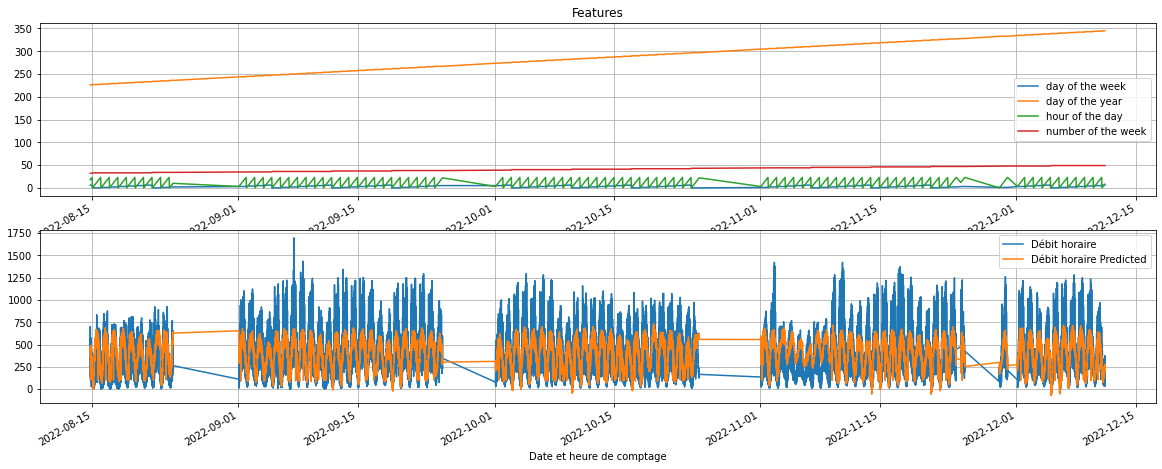

In [16]:
y_test = y_model.reshape(-1, num_labels)

scaler.fit(df[labels])
DF = pd.DataFrame(scaler.inverse_transform(y_test), index=test.iloc[0:ind].index, columns=labels)

fig = plt.figure(figsize=(20, 12))

ax = fig.add_subplot(311)
df[features].loc[DF.index].plot(ax=ax)
plt.grid()
plt.title('Features')

ax = fig.add_subplot(312)
df[labels[0]].loc[DF.index].plot(ax=ax)
DF[labels[0]].plot(ax=ax, label=labels[0]+' Predicted')
plt.legend()
plt.grid()

La périodicité du débit horaire est présente mais les valeurs maximale ne sont pas atteintes.

In [17]:
from math import sqrt
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_pred.reshape(-1,1), ybtest.reshape(-1,1))
print('MSE : %.3f' % mse)
rmse = sqrt(mean_squared_error(y_pred.reshape(-1,1), ybtest.reshape(-1,1)))
print('RMSE : %.3f' % rmse)

MSE : 0.007
RMSE : 0.086


## 4. Conclusion

La `MSE` vaut 0.007 : la prédiction est donc assez précise mais on peut encore l'améliorer, notamment sur les valeurs maximales. On pourrait par exemple entraîner un modèle multi-tâche pour affiner la prédiction pour chaque capteur et donc la prédiction en général.

On pourrait également changer les paramètres du modèle pour améliorer la performance. Par exemple, on pourrait augmenter le nombre de couches LSTM, augmenter le nombre d'itérations d'entraînement ou encore optimiser le `learning_rate`.